In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from hurst import compute_Hc

In [22]:
# Load Dollar Index data from Yahoo Finance
dxy = yf.download('DX-Y.NYB', start='2000-01-01', end='2024-08-24')

[*********************100%***********************]  1 of 1 completed


In [87]:
def compute_hurst(data, start, end, frequency='1d'):
    data_filtered = data.loc[start:end]
    data_resampled = data_filtered['Adj Close'].resample(frequency).last().dropna()
    log_returns = np.log(data_resampled / data_resampled.shift(1)).dropna()
    H, c, hurst_data = compute_Hc(log_returns, kind='change', simplified=True)
    
    return H, c, hurst_data


def freq_check(hurst_data):
    # Extract the log(R/S) and log(n) data
    log_n = np.log10(hurst_data[0])
    log_rs = np.log10(hurst_data[1])

    # Plot log(R/S) vs log(n)
    plt.figure(figsize=(10, 6))
    plt.plot(log_n, log_rs, 'o-', color="dodgerblue")
    plt.xlabel('log(n)')
    plt.ylabel('log(R/S)')
    plt.title('log(R/S) vs log(n)')
    plt.grid(True)
    plt.show()

def plot_hurst(H, c, hurst_data):
    print(f"Hurst exponent: {H}")

    # Plot the Hurst computation result
    plt.figure(figsize=(10, 6))
    plt.plot(hurst_data[0], c * hurst_data[0]**H, color="deepskyblue")
    plt.scatter(hurst_data[0], hurst_data[1], color="dodgerblue")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time interval')
    plt.ylabel('Price change (R/S)')
    plt.title(f'Hurst exponent: {H:.4f}')
    plt.grid(True)
    plt.show()

    # Interpretation
    if H > 0.5:
        print("The time series exhibits persistent (superdiffusive) behavior, indicating positive autocorrelation in volatility.")
    elif H < 0.5:
        print("The time series exhibits anti-persistent (subdiffusive) behavior, indicating negative autocorrelation in volatility.")
    else:
        print("The time series exhibits a random walk (Brownian motion) with no long-term memory.")

In [88]:
H, c, hurst_data = compute_hurst(dxy, '2000-01-01', '2024-08-24')

In [89]:
10**3.25 / 252 # ~linear log log

7.056664325551281

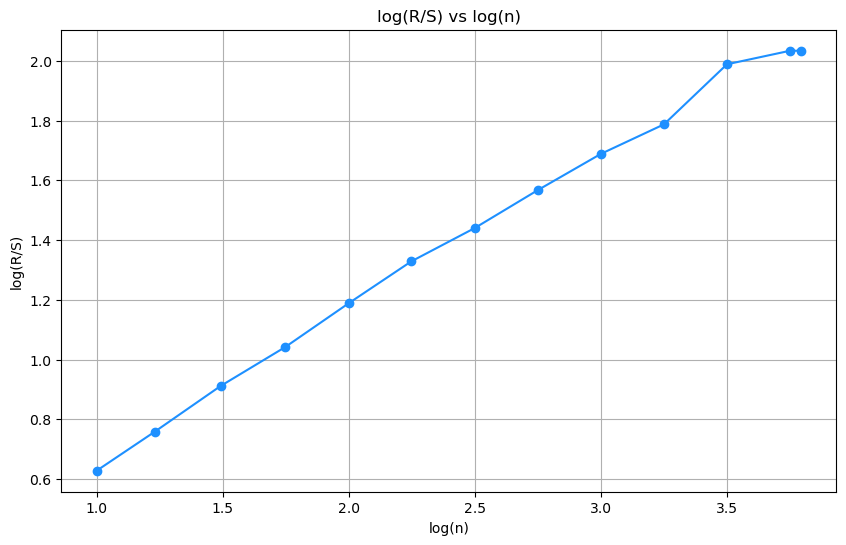

In [82]:
freq_check(hurst_data)
# log(n) ~ 3.25 -> 7 year

Hurst exponent: 0.5098896617112435


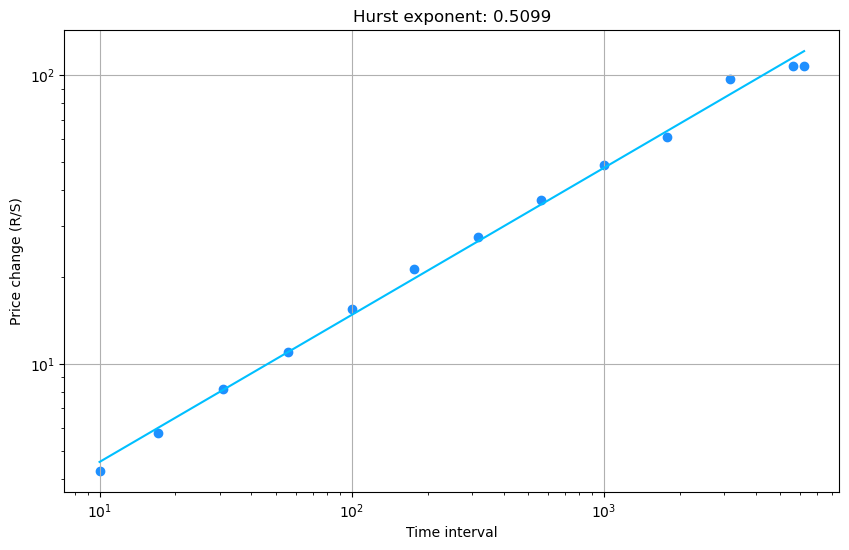

The time series exhibits persistent (superdiffusive) behavior, indicating positive autocorrelation in volatility.


In [83]:
plot_hurst(H, c, hurst_data)
# this H=0.51 is valid (slightly off) within first 7 years (2000-2007) across all frequency <= '1d'

In [84]:
int(len(dxy) - 10**3.5) // 252 # latest valid linear relation of log log

12

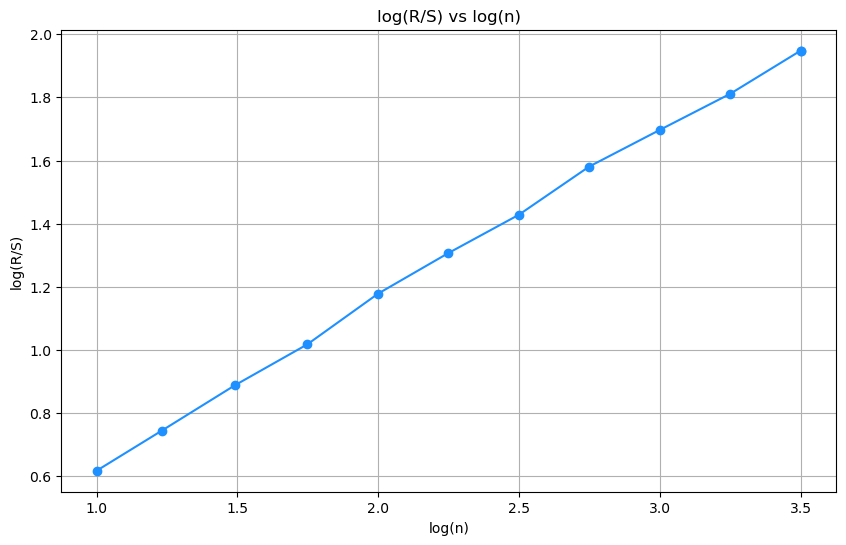

In [111]:
cur_H, cur_c, cur_hurst_data = compute_hurst(dxy, '2012-01-01', '2024-08-24')
freq_check(cur_hurst_data)

Hurst exponent: 0.531513476693141


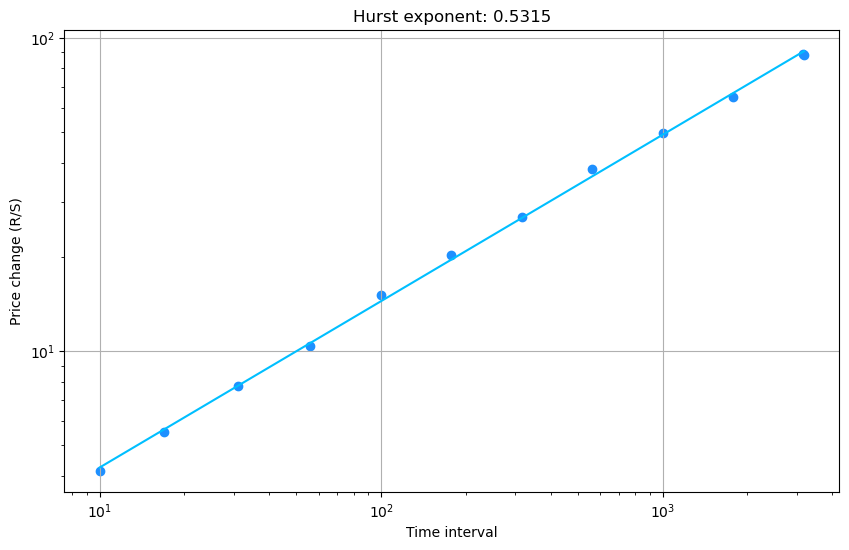

The time series exhibits persistent (superdiffusive) behavior, indicating positive autocorrelation in volatility.


In [112]:
# '2012-01-01', '2024-08-24'
plot_hurst(cur_H, cur_c, cur_hurst_data)

$$ B_H(t + \tau) - B_H(t) \triangleq k^{-H} [B_H(t + k\tau) - B_H(t)] $$

- Within the context of fractal pattern (same H across frequencies), Dollar index log return series's volatility has slightly higher autocorrelation than 12 year's ago
- But beyond that, things are different. The main point is to simplify the long term volatility modelling

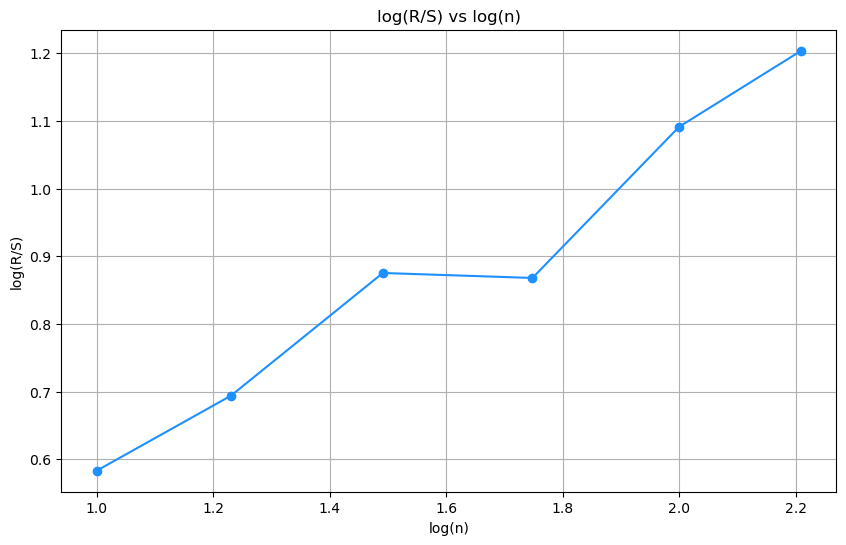

In [110]:
H, c, hurst_data = compute_hurst(dxy, '2024-01-01', '2024-08-24')
freq_check(hurst_data)

In [113]:
def model_volatility_with_hurst(log_returns, H, c, hurst_data, window=30):
    # Calculate rolling volatility (standard deviation) over the specified window
    rolling_volatility = log_returns.rolling(window=window).std()
    
    # Adjust the volatility using the Hurst exponent
    if H > 0.5:
        # Increase volatility for persistent behavior
        adjusted_volatility = rolling_volatility * (H * c)
    elif H < 0.5:
        # Decrease volatility for anti-persistent behavior
        adjusted_volatility = rolling_volatility * (1 - H)
    else:
        # No adjustment for random walk
        adjusted_volatility = rolling_volatility
    
    # Plot the original vs adjusted volatility
    plt.figure(figsize=(14, 7))
    plt.plot(rolling_volatility, label='Original Rolling Volatility', color='blue')
    plt.plot(adjusted_volatility, label='Adjusted Volatility with Hurst', color='red')
    plt.title('Volatility Modeling with Hurst Exponent')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return adjusted_volatility

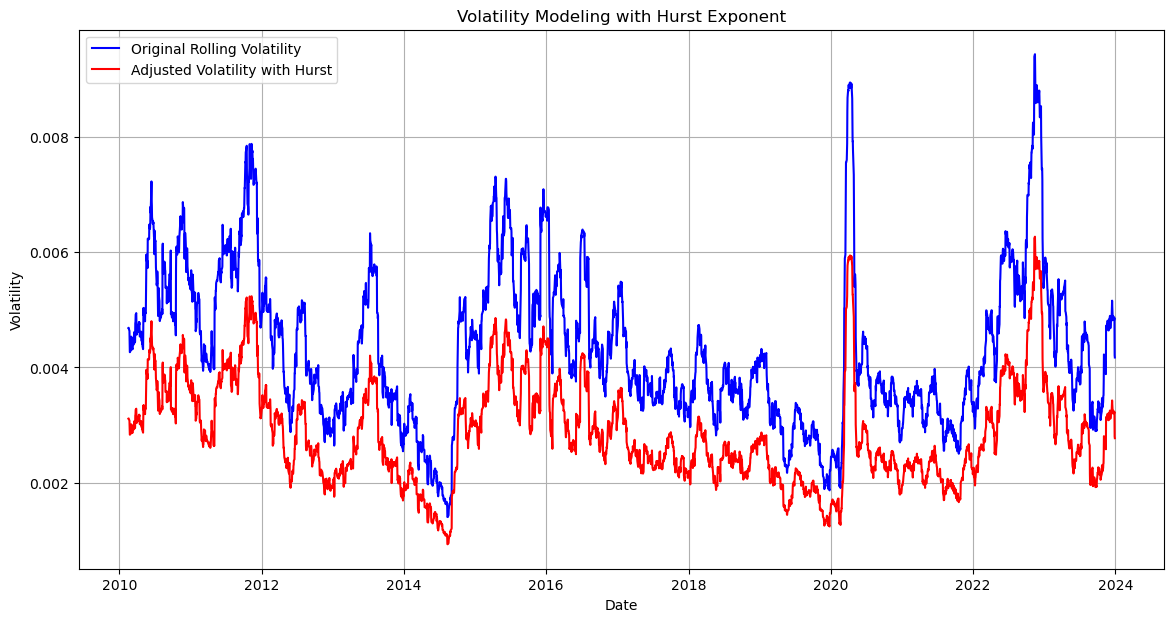

In [116]:
# Calculate log returns for the same period
data_filtered = dxy.loc['2010-01-01':'2024-01-01']
log_returns = np.log(data_filtered['Adj Close'].resample('1d').last().dropna() / 
                     data_filtered['Adj Close'].resample('1d').last().dropna().shift(1)).dropna()

# Model the volatility using the computed Hurst exponent
adjusted_volatility = model_volatility_with_hurst(log_returns, cur_H, cur_c, cur_hurst_data)